# <a id='1'>0. Sommaire</a>

- <a href='#1'>0. Sommaire</a>  
- <a href='#2'>1. Librairies</a>
- <a href='#3'>2. Paramètres MLFLOW</a>
- <a href='#4'>3. Data</a>
- <a href='#5'>4. Modelisation</a>

# <a id='1'>1. Librairies</a>

In [2]:
import pandas as pd
import numpy as np

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

In [3]:
from pycaret.classification import *
import pickle
import shap

In [4]:
import time
from contextlib import contextmanager
@contextmanager

def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# <a id='3'>3. Data</a>

In [5]:
# Data de "reference" utilisée pour l'entraînement du modèle
train_df = pd.read_csv(r'Data\application_train.csv')
# "current_data", données en production, correspondant à des nouveaux clients
test_df = pd.read_csv(r'Data\application_test.csv')

## <a id='5'>4. Data Drift</a>

In [10]:
feature_a_etudier = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]
train_df=train_df.filter(feature_a_etudier)
test_df=test_df.filter(feature_a_etudier)

In [11]:
# Column mapping 
column_mapping = ColumnMapping()
column_mapping.numerical_features = train_df.select_dtypes(exclude=['object']).columns.tolist() #list of numerical features
column_mapping.categorical_features = train_df.select_dtypes(include=['object']).columns.tolist() # list of categ features

In [12]:
with timer('Création du rapport de dataDrift') :
    report = Report(metrics=[DataDriftPreset(), ]) # choix du rapport "DataDriftPreset"
    report.run(column_mapping = column_mapping, reference_data=train_df, current_data=test_df) # Création du rapport
    report.save_html("data_drift_analysis.html") # sauvegarde du rapport au format html( pas possible de l'affiche dans le notebo

Création du rapport de dataDrift - done in 2782s


## <a id='5'>4. SHAP</a>

In [181]:
df = pd.read_pickle(r".\Data\Processed_data\df_final_prot5.pkl")

In [182]:
with open(r'.\Data\Processed_data\var_cons_df.pickle', 'rb') as f:
    features_to_keep = pickle.load(f)

In [183]:
features_to_keep = features_to_keep['variables'].to_list()

In [184]:
features_to_ignore = list(set(df.keys().to_list()) - set(features_to_keep))
features_to_ignore.remove('TARGET')

In [185]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [186]:
test_df.drop('TARGET', axis = 1, inplace = True)

In [187]:
s = setup(data = train_df, 
          target = 'TARGET', 
          train_size = 0.8,
          ignore_features = features_to_ignore,
          normalize = True,
          normalize_method="robust",
          session_id=42)

,Description,Value
0,Session id,42
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 546)"
4,Transformed data shape,"(307507, 160)"
5,Transformed train set shape,"(246005, 160)"
6,Transformed test set shape,"(61502, 160)"
7,Ignore features,386
8,Numeric features,159
9,Preprocess,True


In [188]:
X_train = get_config('X_transformed')
y_train = get_config('y_transformed')

In [207]:
pipeline_shap = load_model('model_shap')

Transformation Pipeline and Model Successfully Loaded


In [208]:
pipeline= load_model('model')

Transformation Pipeline and Model Successfully Loaded


In [214]:
df_pred = predict_model(pipeline, test_df, raw_score = True)
df_pred[['SK_ID_CURR','prediction_label','prediction_score_0','prediction_score_1']].head(10)

,SK_ID_CURR,prediction_label,prediction_score_0,prediction_score_1
307507,100001.0,0,0.5598,0.4402
307508,100005.0,1,0.2687,0.7313
307509,100013.0,0,0.8375,0.1625
307510,100028.0,0,0.6263,0.3737
307511,100038.0,1,0.3421,0.6579
307512,100042.0,0,0.6196,0.3804
307513,100057.0,0,0.9032,0.0968
307514,100065.0,0,0.6214,0.3786
307515,100066.0,0,0.7613,0.2387
307516,100067.0,0,0.5662,0.4338


In [213]:
df_pred_shap = predict_model(pipeline_shap, test_df, raw_score = True)
df_pred_shap[['SK_ID_CURR','prediction_label','prediction_score_0','prediction_score_1']].head(10)

,SK_ID_CURR,prediction_label,prediction_score_0,prediction_score_1
307507,100001.0,0,0.5598,0.4402
307508,100005.0,1,0.2687,0.7313
307509,100013.0,0,0.8375,0.1625
307510,100028.0,0,0.6263,0.3737
307511,100038.0,1,0.3421,0.6579
307512,100042.0,0,0.6196,0.3804
307513,100057.0,0,0.9032,0.0968
307514,100065.0,0,0.6214,0.3786
307515,100066.0,0,0.7613,0.2387
307516,100067.0,0,0.5662,0.4338


In [196]:
fitted_model = model.fit(X_train, y_train)

In [223]:
train_pipe = pipeline_shap[:-1].transform(train_df[features_to_keep])
test_pipe = pipeline_shap[:-1].transform(test_df[features_to_keep])

In [219]:
pipeline_shap.named_steps["actual_estimator"]

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [233]:
explainer = shap.Explainer(pipeline_shap.named_steps["actual_estimator"].predict, test_pipe)

In [235]:
#shap_values = explainer.shap_values(test_pipe)
shap_values = explainer(test_pipe)

Permutation explainer: 48745it [5:01:27,  2.69it/s]                             


In [259]:
shap_values

.values =
array([[-0.13 ,  0.035,  0.   , ...,  0.02 , -0.015,  0.025],
       [ 0.23 ,  0.035,  0.   , ..., -0.03 ,  0.005,  0.005],
       [ 0.04 ,  0.005,  0.   , ...,  0.   , -0.01 , -0.005],
       ...,
       [-0.02 , -0.005,  0.   , ...,  0.   ,  0.   ,  0.01 ],
       [ 0.05 ,  0.02 ,  0.   , ...,  0.03 , -0.015,  0.   ],
       [-0.04 , -0.03 ,  0.   , ...,  0.01 ,  0.   ,  0.01 ]])

.base_values =
array([0.32, 0.32, 0.32, ..., 0.32, 0.32, 0.32])

.data =
array([[ 0.        ,  0.        ,  0.        , ..., -4.6506023 ,
        -1.7165118 ,  0.09228767],
       [-1.        ,  0.        ,  0.        , ..., -1.1626506 ,
         0.18519628,  0.33045638],
       [-1.        ,  1.        ,  0.        , ...,  0.21084337,
        -0.71201676, -4.61231   ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.15361446,
         0.21276596,  0.3496227 ],
       [-1.        ,  0.        ,  1.        , ...,  0.21385542,
        -0.19298771, -0.18397261],
       [ 0.        

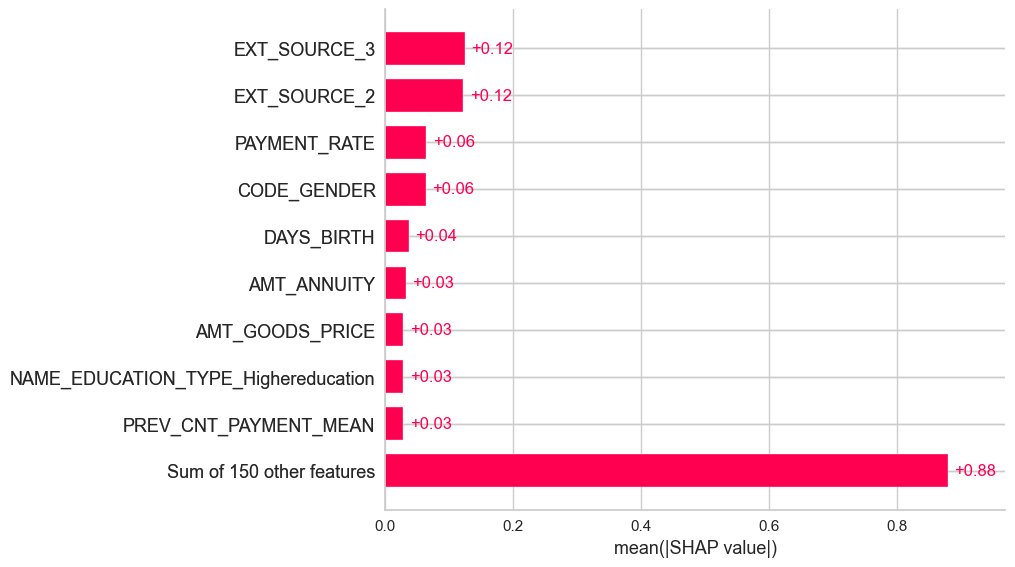

In [239]:
shap.plots.bar(shap_values)

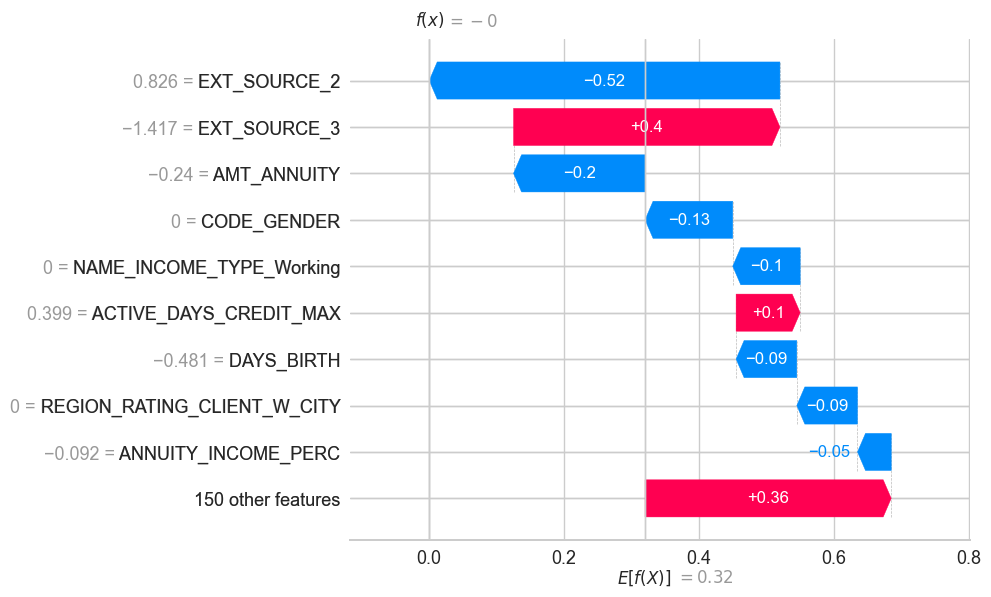

In [253]:
shap.plots.waterfall(shap_values[0])

In [260]:
# Sauvegarde des valeurs Shapley
shap_values_pkl = r'Data\Processed_data\230616_shap_values.pickle'
with open(shap_values_pkl, 'wb') as f:
    pickle.dump(shap_values, f, pickle.HIGHEST_PROTOCOL)

In [261]:
# Sauvegarde des valeurs Shapley
explainer_pkl = r'Data\Processed_data\230616_explainer.pickle'
with open(explainer_pkl, 'wb') as f:
    pickle.dump(explainer, f, pickle.HIGHEST_PROTOCOL)